# October 11th, 2021

**Motivation**: Exploring 2D ROIs a little more in depth.  Things looking good.  Ready to get full blown results. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import Allen
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from register.register import ants, reset_ants_img

## 256

In [3]:
mice = Mice(Config(256, 4, 100), load_preproc=True, load_allen=True, load_parcel=True)

In [4]:
mice.parcel.fill_rois_2d()

### Load one individual Ca

In [5]:
key = 'sub-SLC08_ses-2'

mask = mice.mask2d[key].load_ants('unsigned int')

roi_2d = ants.image_read(
    filename=pjoin(mice.cfg.masks_dir, f"{key}_space-indiv2d_cortex-merged.nii.gz"),
    pixeltype='unsigned int',
)
roi_2d = reset_ants_img(roi_2d.numpy().squeeze(), spacing=roi_2d.spacing[:2], origin=0, use_um=False)

ref = mice.ref[key].load_ants('float')
ref = reset_ants_img(ref.numpy().squeeze(), spacing=ref.spacing[:2], origin=0, use_um=False)

roi_2d = ants.resample_image_to_target(roi_2d, mask, interp_type='genericLabel')
ref = ants.resample_image_to_target(ref, mask, interp_type='linear')

roi_2d *= mask
ref *= mask

<matplotlib.image.AxesImage object at 0x7ea89ec57130>

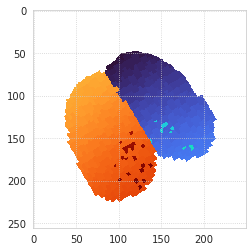

In [6]:
roi_2d_np = roi_2d.numpy().astype(int).squeeze()
regions2d = np.unique(roi_2d_np[roi_2d_np.nonzero()])

roi_2d_np = roi_2d_np.astype(float)
roi_2d_np[roi_2d_np == 0] = np.nan

plt.imshow(roi_2d_np, cmap='turbo')

In [7]:
len(regions2d)

329

In [8]:
hcl = mice.parcel.decode(regions2d)[0]

In [9]:
sizes = collections.Counter(roi_2d_np[~np.isnan(roi_2d_np)])
sizes_np = np.array(list(sizes.values()))

In [10]:
min(sizes_np)

3

<AxesSubplot:ylabel='Count'>

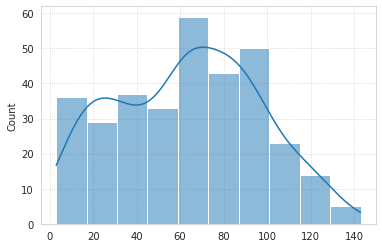

In [11]:
sns.histplot(sizes_np, kde=True)

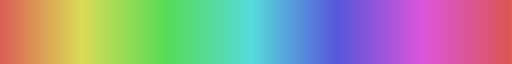

In [12]:
sns.color_palette('hls', as_cmap=True)

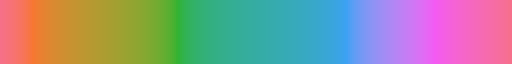

In [13]:
sns.color_palette('husl', as_cmap=True)

### Load all compare

In [14]:
flat = pjoin(mice.cfg.main_dir, 'parcel2d-flat_10um.nii.gz')
flat = ants.image_read(flat, pixeltype='unsigned int').numpy()
top = pjoin(mice.cfg.main_dir, 'parcel2d-top_10um.nii.gz')
top = ants.image_read(top, pixeltype='unsigned int').numpy()

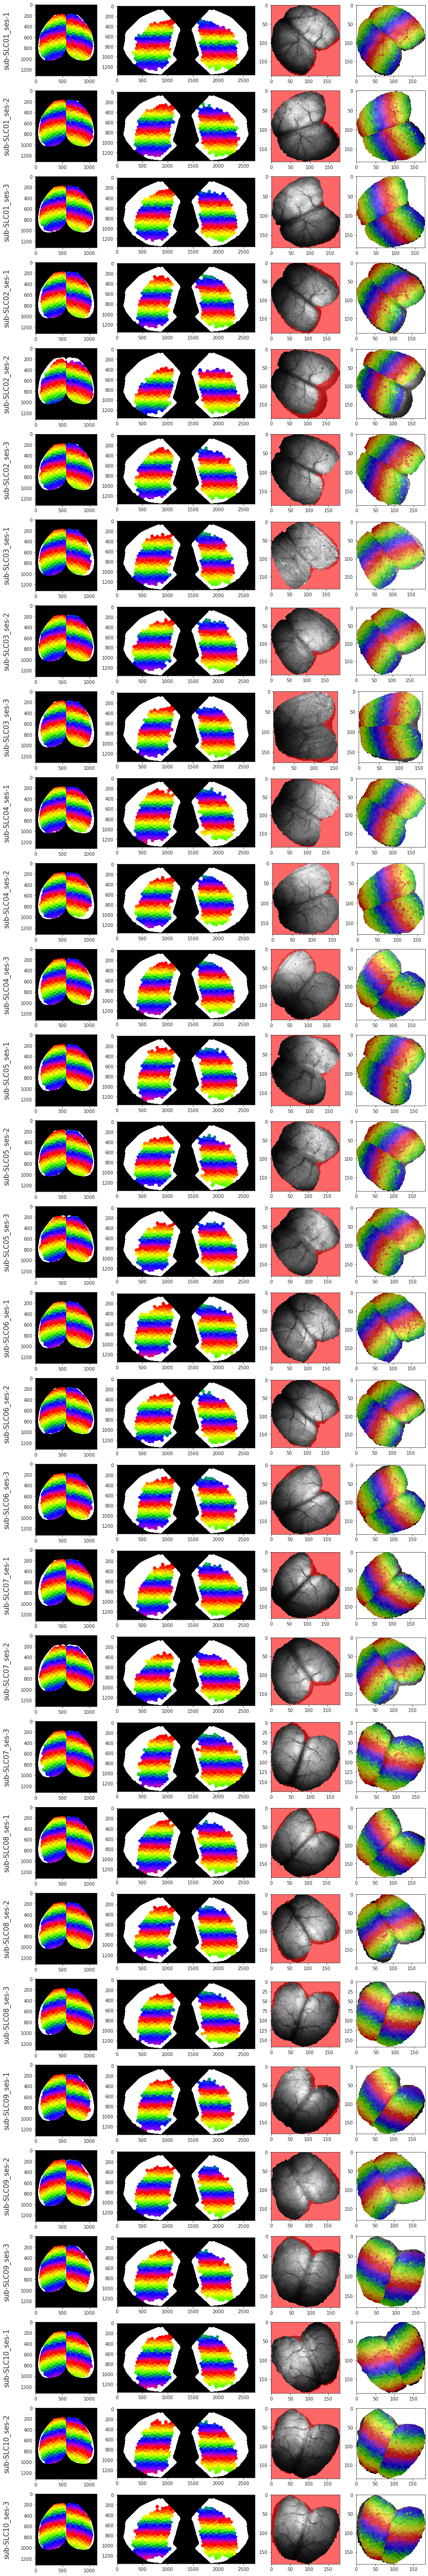

In [15]:
nrows = 30
fig, axes = create_figure(nrows, 4, (13, 2.6 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 1]})

dlist = []
regions_all = {}
for ii, key in enumerate(mice.ref):
    roi_2d = pjoin(mice.cfg.masks_dir, f"{key}_space-indiv2d_cortex-merged.nii.gz")
    roi_2d = ants.image_read(filename=roi_2d, pixeltype='unsigned int')
    roi_2d = reset_ants_img(roi_2d.numpy().squeeze(), spacing=roi_2d.spacing[:2], origin=0, use_um=False)

    ref = mice.ref[key].load_ants('float')
    ref = reset_ants_img(ref.numpy().squeeze(), spacing=ref.spacing[:2], origin=0, use_um=False)

    mask = mice.mask2d[key].load_ants('unsigned int')
    roi_2d = ants.resample_image_to_target(roi_2d, mask, interp_type='genericLabel')
    ref = ants.resample_image_to_target(ref, mask, interp_type='linear')
    roi_2d *= mask
    ref *= mask

    roi_2d_np = roi_2d.numpy().astype(int).squeeze()
    sizes = collections.Counter(roi_2d_np[roi_2d_np.nonzero()])
    dlist.append({
        'key': [key] * len(sizes),
        'region': sizes.keys(),
        'pixels': sizes.values(),
    })
    
    regions2d = np.unique(roi_2d_np[roi_2d_np.nonzero()])
    regions_all[key] = list(regions2d)

    ref_tr, roi_tr, mask_tr = filter_boundaries(
        [ref.numpy(), roi_2d.numpy(), mask.numpy()], mask.numpy())
    ref_tr = ref_tr.astype(float)
    roi_tr = roi_tr.astype('uint32')
    mask_tr = mask_tr.astype(bool)
    
    axes[ii, 0].set_ylabel(f"{key}\n", fontsize=15)

    data2plt = np.ma.masked_where(~np.isin(top, regions2d), top)
    axes[ii, 0].imshow(top > 0, cmap='Greys_r')
    axes[ii, 0].imshow(data2plt, cmap='prism')

    data2plt = np.ma.masked_where(~np.isin(flat, regions2d), flat)
    axes[ii, 1].imshow(flat > 0, cmap='Greys_r')
    axes[ii, 1].imshow(data2plt, cmap='prism')

    axes[ii, 2].imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
    axes[ii, 2].imshow(np.ma.masked_where(roi_tr.astype(bool), roi_tr), alpha=0.6, cmap='prism')

    axes[ii, 3].imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
    axes[ii, 3].imshow(np.ma.masked_where(~roi_tr.astype(bool), roi_tr), alpha=0.6, cmap='prism')

plt.show()

df_sz = pd.DataFrame(merge_dicts(dlist))

In [16]:
regions_agg = []
for item in regions_all.values():
    regions_agg += item
freq = collections.Counter(regions_agg)
freq = {i: 100 * v / 30 for i, v in freq.items()}

freq_top = np.zeros(top.shape)
freq_flat = np.zeros(flat.shape)

for i, val in freq.items():
    freq_top[top == i] = val
    freq_flat[flat == i] = val

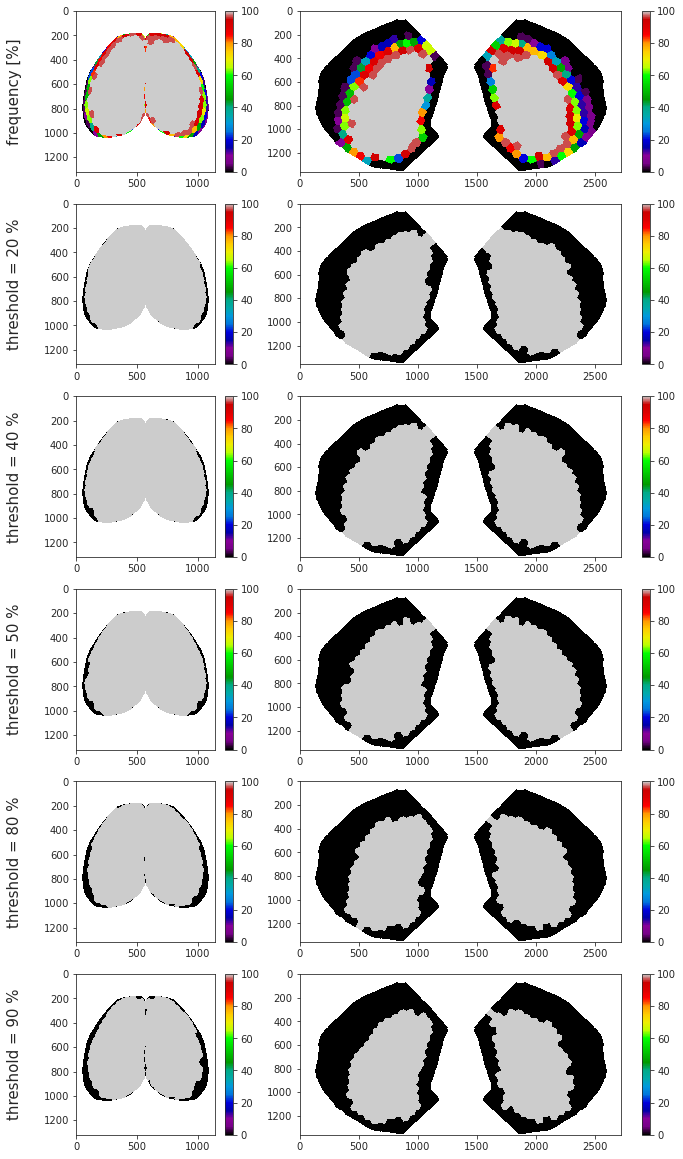

In [17]:
nrows = 6
fig, axes = create_figure(nrows, 2, (10, 2.7 * nrows), gridspec_kw={'width_ratios': [1, 2]})

axes[0, 0].set_ylabel('frequency [%]\n', fontsize=15)

data2plt = np.ma.masked_where(~top.astype(bool), freq_top)
im = axes[0, 0].imshow(data2plt, cmap='nipy_spectral')
plt.colorbar(im, ax=axes[0, 0])

data2plt = np.ma.masked_where(~flat.astype(bool), freq_flat)
im = axes[0, 1].imshow(data2plt, cmap='nipy_spectral')
plt.colorbar(im, ax=axes[0, 1])

for i, th in enumerate([20, 40, 50, 80, 90], start=1):
    axes[i, 0].set_ylabel(f"threshold = {th:d} %\n", fontsize=15)
    
    x = freq_top.copy()
    x[x > th] = 100.
    x[x <= th] = 0.
    data2plt = np.ma.masked_where(~top.astype(bool), x)
    im = axes[i, 0].imshow(data2plt, cmap='nipy_spectral')
    plt.colorbar(im, ax=axes[i, 0])

    x = freq_flat.copy()
    x[x > th] = 100.
    x[x <= th] = 0.
    data2plt = np.ma.masked_where(~flat.astype(bool), x)
    im = axes[i, 1].imshow(data2plt, cmap='nipy_spectral')
    plt.colorbar(im, ax=axes[i, 1])

plt.show()

In [18]:
len(freq)

464

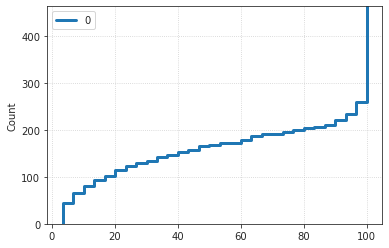

In [19]:
sns.ecdfplot(freq.values(), stat='count', lw=3)
plt.grid()

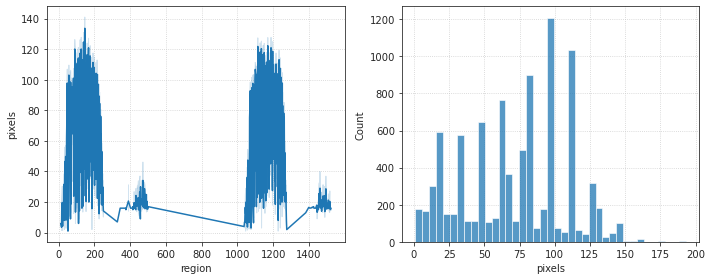

In [20]:
fig, axes = create_figure(1, 2, (10, 4))

sns.lineplot(data=df_sz, x='region', y='pixels', ax=axes[0])
sns.histplot(data=df_sz, x='pixels', ax=axes[1])
for ax in axes.ravel():
    ax.grid()

plt.show()

<matplotlib.image.AxesImage object at 0x7eb13303dc40>

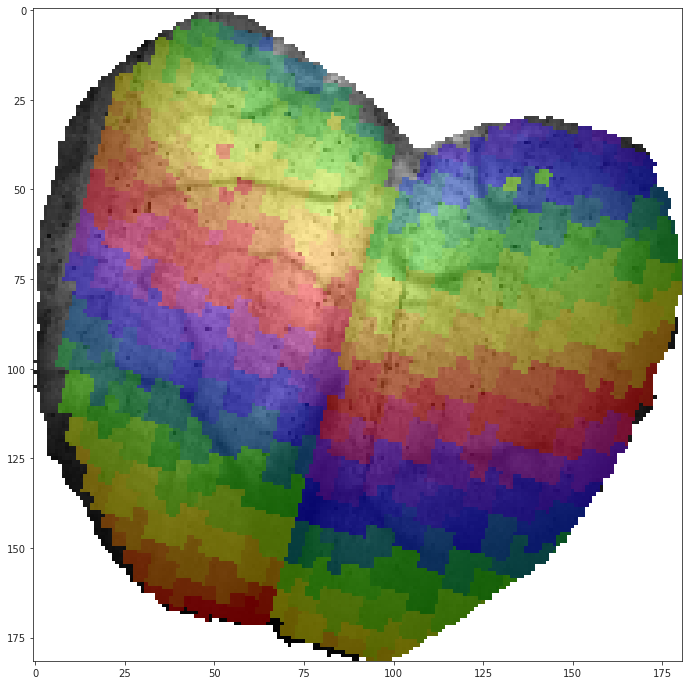

In [21]:
plt.figure(figsize=(15, 12))
plt.imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
plt.imshow(np.ma.masked_where(~roi_tr.astype(bool), roi_tr), alpha=0.4, cmap='prism')

## 512

In [22]:
mice = Mice(Config(512, 4, 100), load_preproc=True, load_allen=True, load_parcel=True)

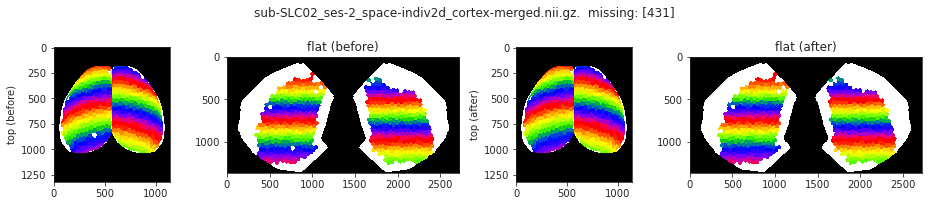

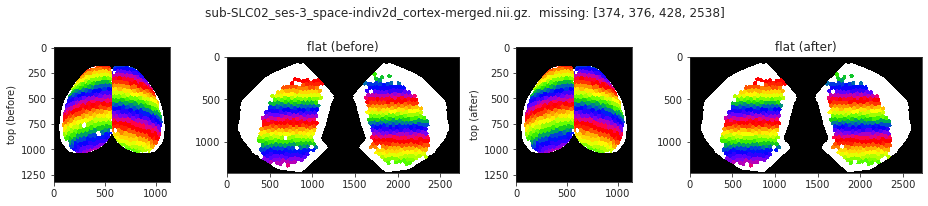

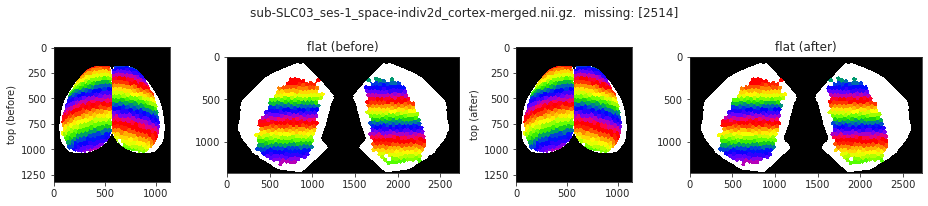

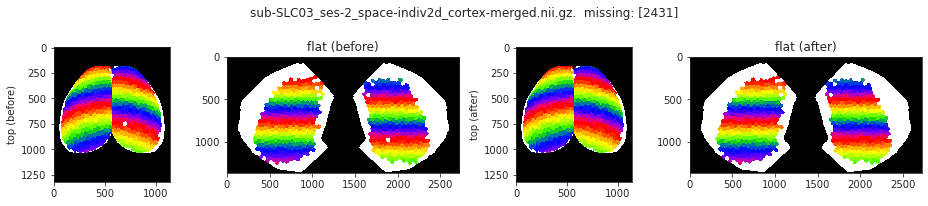

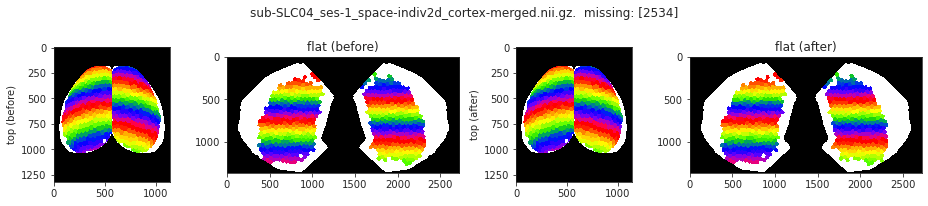

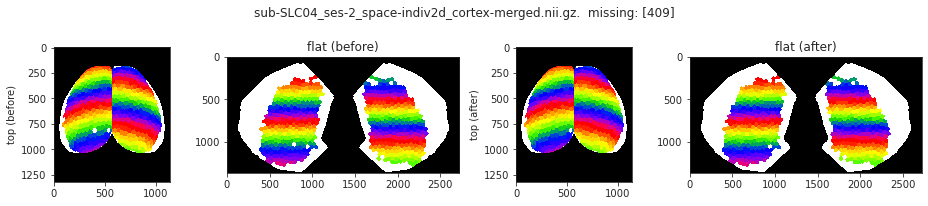

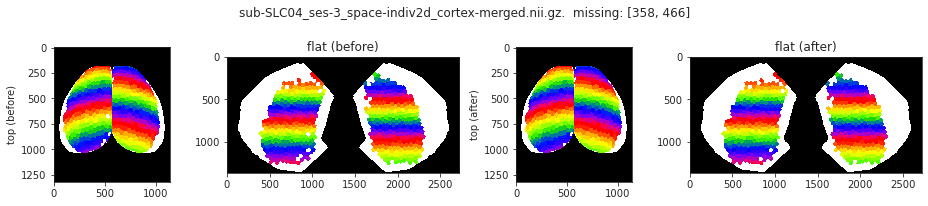

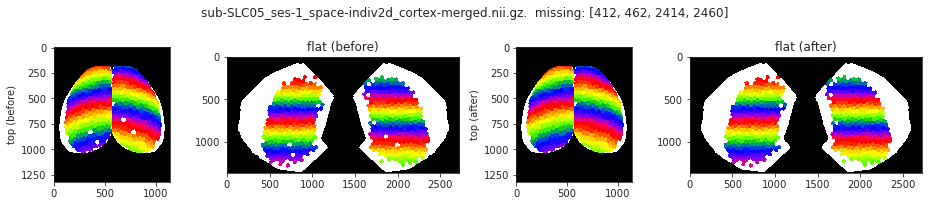

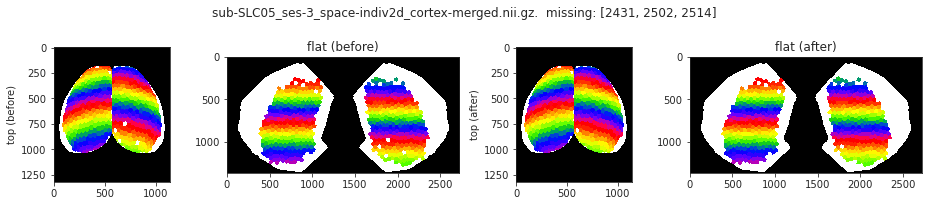

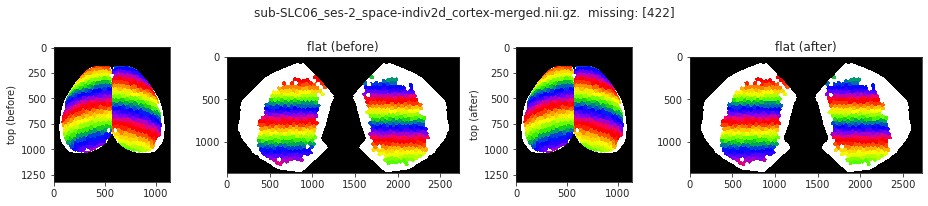

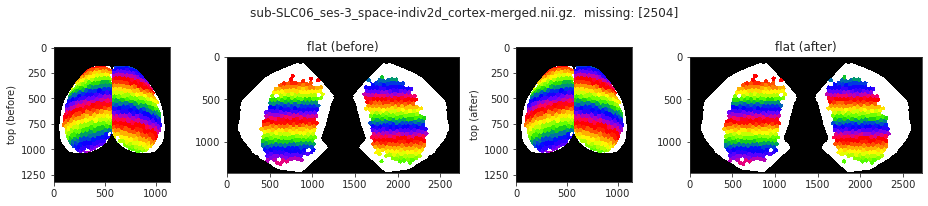

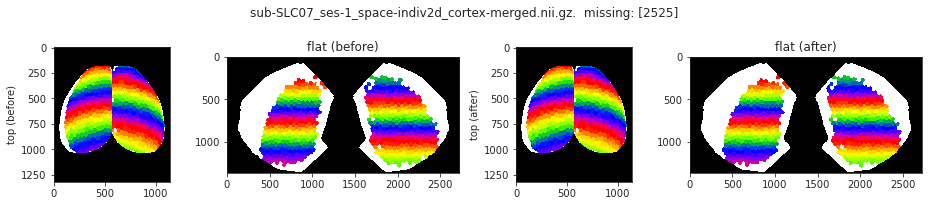

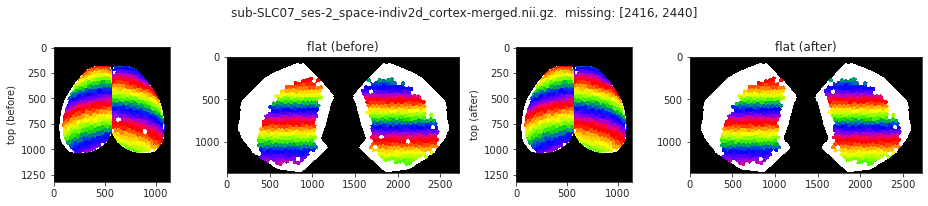

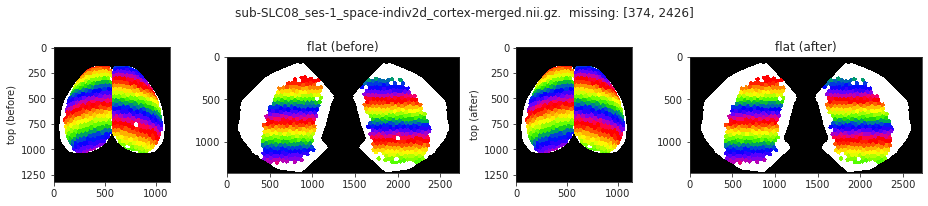

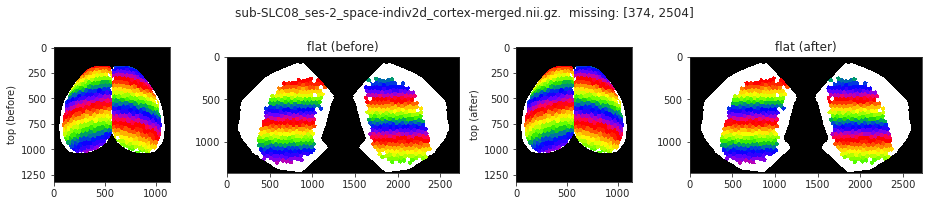

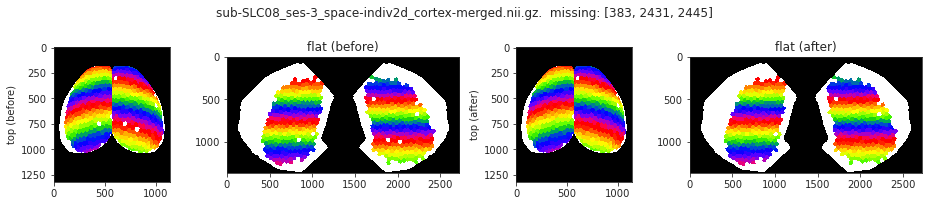

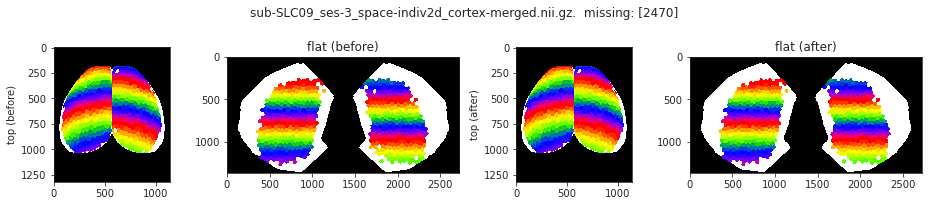

In [23]:
mice.parcel.fill_rois_2d()

In [24]:
mice.parcel.fill_rois_2d()

### Load all compare

In [25]:
flat = pjoin(mice.cfg.main_dir, 'parcel2d-flat_10um.nii.gz')
flat = ants.image_read(flat, pixeltype='unsigned int').numpy()
top = pjoin(mice.cfg.main_dir, 'parcel2d-top_10um.nii.gz')
top = ants.image_read(top, pixeltype='unsigned int').numpy()

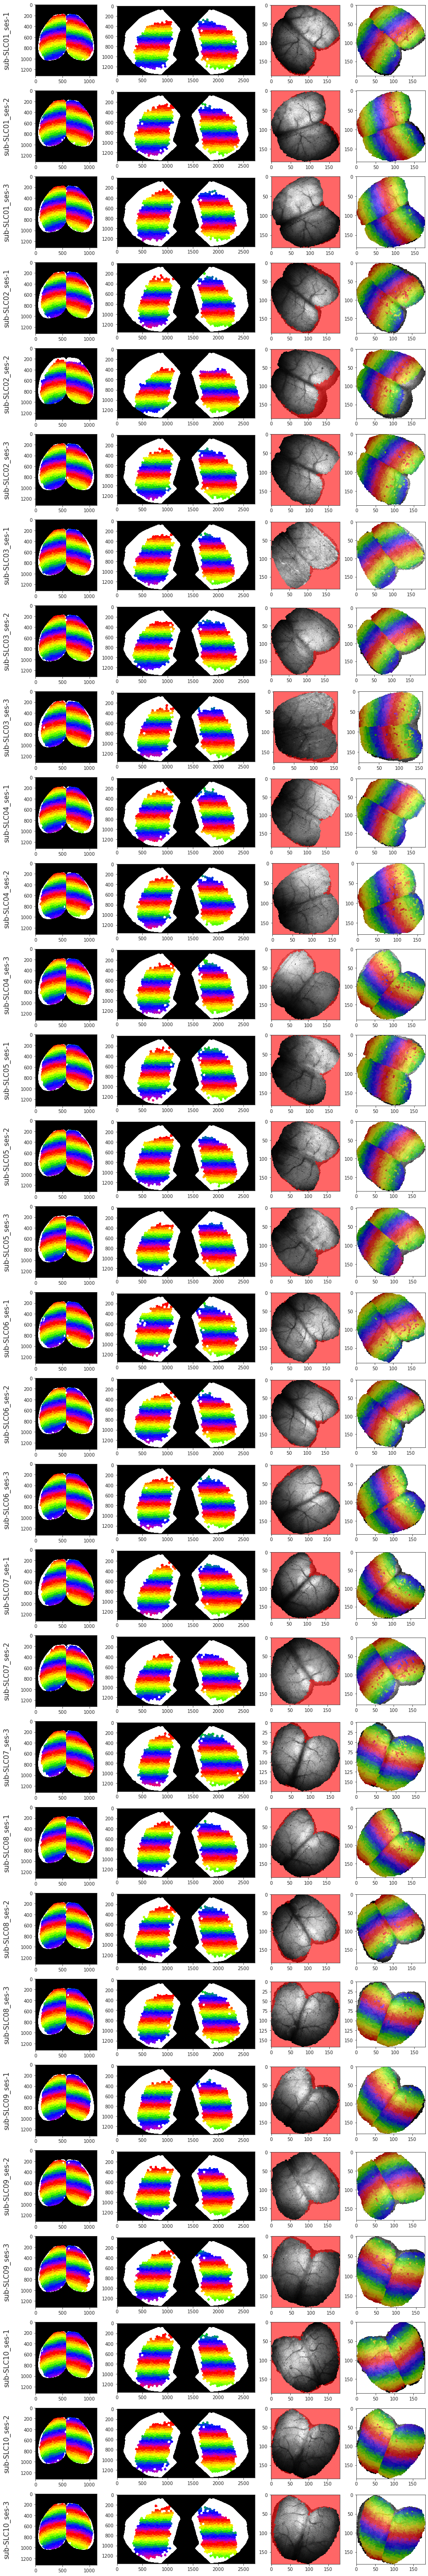

In [26]:
nrows = 30
fig, axes = create_figure(nrows, 4, (13, 2.6 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 1]})

dlist = []
regions_all = {}
for ii, key in enumerate(mice.ref):
    roi_2d = pjoin(mice.cfg.masks_dir, f"{key}_space-indiv2d_cortex-merged.nii.gz")
    roi_2d = ants.image_read(filename=roi_2d, pixeltype='unsigned int')
    roi_2d = reset_ants_img(roi_2d.numpy().squeeze(), spacing=roi_2d.spacing[:2], origin=0, use_um=False)

    ref = mice.ref[key].load_ants('float')
    ref = reset_ants_img(ref.numpy().squeeze(), spacing=ref.spacing[:2], origin=0, use_um=False)

    mask = mice.mask2d[key].load_ants('unsigned int')
    roi_2d = ants.resample_image_to_target(roi_2d, mask, interp_type='genericLabel')
    ref = ants.resample_image_to_target(ref, mask, interp_type='linear')
    roi_2d *= mask
    ref *= mask

    roi_2d_np = roi_2d.numpy().astype(int).squeeze()
    sizes = collections.Counter(roi_2d_np[roi_2d_np.nonzero()])
    dlist.append({
        'key': [key] * len(sizes),
        'region': sizes.keys(),
        'pixels': sizes.values(),
    })
    
    regions2d = np.unique(roi_2d_np[roi_2d_np.nonzero()])
    regions_all[key] = list(regions2d)

    ref_tr, roi_tr, mask_tr = filter_boundaries(
        [ref.numpy(), roi_2d.numpy(), mask.numpy()], mask.numpy())
    ref_tr = ref_tr.astype(float)
    roi_tr = roi_tr.astype('uint32')
    mask_tr = mask_tr.astype(bool)
    
    axes[ii, 0].set_ylabel(f"{key}\n", fontsize=15)

    data2plt = np.ma.masked_where(~np.isin(top, regions2d), top)
    axes[ii, 0].imshow(top > 0, cmap='Greys_r')
    axes[ii, 0].imshow(data2plt, cmap='prism')

    data2plt = np.ma.masked_where(~np.isin(flat, regions2d), flat)
    axes[ii, 1].imshow(flat > 0, cmap='Greys_r')
    axes[ii, 1].imshow(data2plt, cmap='prism')

    axes[ii, 2].imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
    axes[ii, 2].imshow(np.ma.masked_where(roi_tr.astype(bool), roi_tr), alpha=0.6, cmap='prism')

    axes[ii, 3].imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
    axes[ii, 3].imshow(np.ma.masked_where(~roi_tr.astype(bool), roi_tr), alpha=0.6, cmap='prism')

plt.show()

df_sz = pd.DataFrame(merge_dicts(dlist))

In [27]:
regions_agg = []
for item in regions_all.values():
    regions_agg += item
freq = collections.Counter(regions_agg)
freq = {i: 100 * v / 30 for i, v in freq.items()}

freq_top = np.zeros(top.shape)
freq_flat = np.zeros(flat.shape)

for i, val in freq.items():
    freq_top[top == i] = val
    freq_flat[flat == i] = val

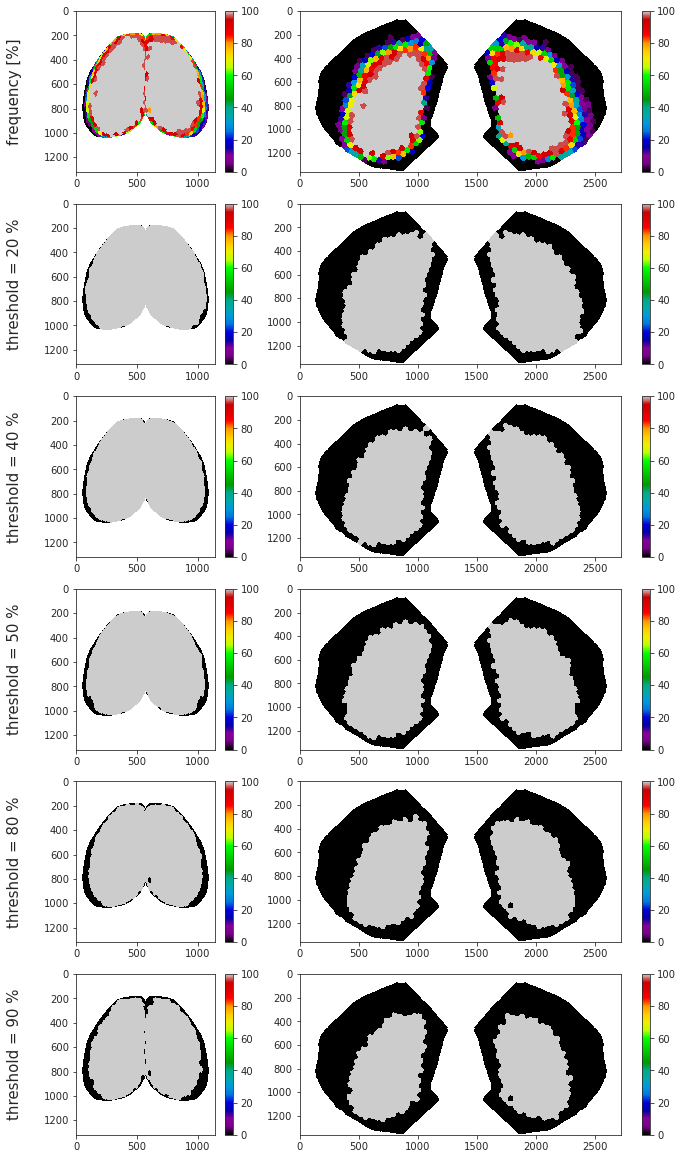

In [28]:
nrows = 6
fig, axes = create_figure(nrows, 2, (10, 2.7 * nrows), gridspec_kw={'width_ratios': [1, 2]})

axes[0, 0].set_ylabel('frequency [%]\n', fontsize=15)

data2plt = np.ma.masked_where(~top.astype(bool), freq_top)
im = axes[0, 0].imshow(data2plt, cmap='nipy_spectral')
plt.colorbar(im, ax=axes[0, 0])

data2plt = np.ma.masked_where(~flat.astype(bool), freq_flat)
im = axes[0, 1].imshow(data2plt, cmap='nipy_spectral')
plt.colorbar(im, ax=axes[0, 1])

for i, th in enumerate([20, 40, 50, 80, 90], start=1):
    axes[i, 0].set_ylabel(f"threshold = {th:d} %\n", fontsize=15)
    
    x = freq_top.copy()
    x[x > th] = 100.
    x[x <= th] = 0.
    data2plt = np.ma.masked_where(~top.astype(bool), x)
    im = axes[i, 0].imshow(data2plt, cmap='nipy_spectral')
    plt.colorbar(im, ax=axes[i, 0])

    x = freq_flat.copy()
    x[x > th] = 100.
    x[x <= th] = 0.
    data2plt = np.ma.masked_where(~flat.astype(bool), x)
    im = axes[i, 1].imshow(data2plt, cmap='nipy_spectral')
    plt.colorbar(im, ax=axes[i, 1])

plt.show()

In [29]:
len(freq)

888

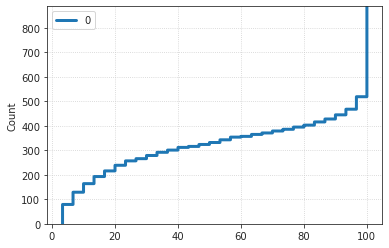

In [30]:
sns.ecdfplot(freq.values(), stat='count', lw=3)
plt.grid()

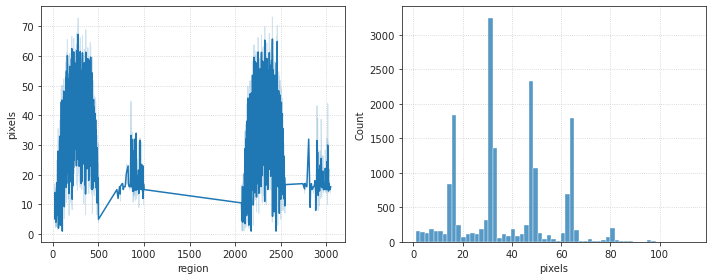

In [31]:
fig, axes = create_figure(1, 2, (10, 4))

sns.lineplot(data=df_sz, x='region', y='pixels', ax=axes[0])
sns.histplot(data=df_sz, x='pixels', ax=axes[1])
for ax in axes.ravel():
    ax.grid()

plt.show()

<matplotlib.image.AxesImage object at 0x7e91e54d8e80>

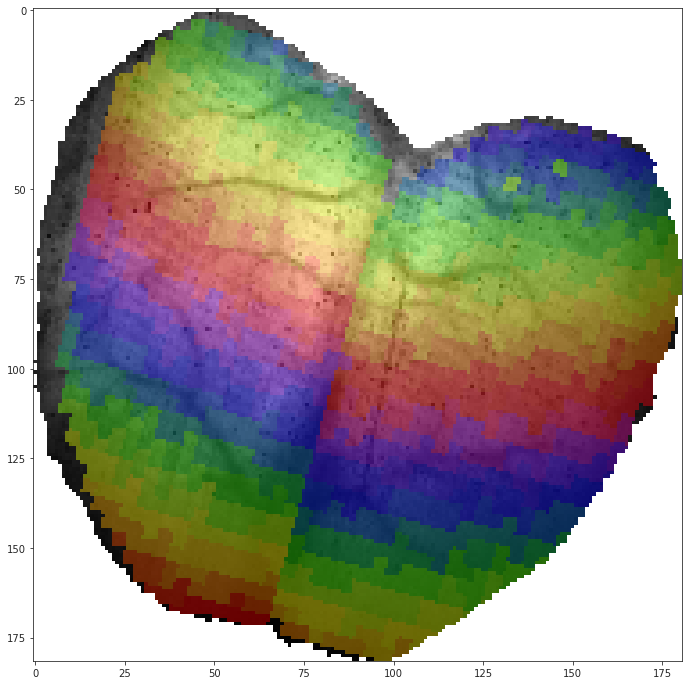

In [32]:
plt.figure(figsize=(15, 12))
plt.imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
plt.imshow(np.ma.masked_where(~roi_tr.astype(bool), roi_tr), alpha=0.4, cmap='prism')

### Why layer 1 appears? (it should all be layer 0)

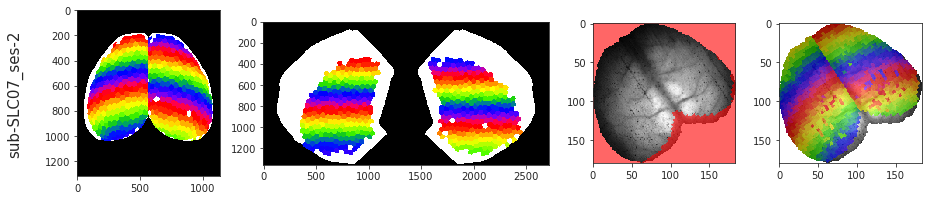

In [45]:
fig, axes = create_figure(1, 4, (13, 2.6 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 1]})

roi_2d = pjoin(mice.cfg.masks_dir, f"{key}_space-indiv2d_cortex-merged.nii.gz")
roi_2d = ants.image_read(filename=roi_2d, pixeltype='unsigned int')
roi_2d = reset_ants_img(roi_2d.numpy().squeeze(), spacing=roi_2d.spacing[:2], origin=0, use_um=False)

ref = mice.ref[key].load_ants('float')
ref = reset_ants_img(ref.numpy().squeeze(), spacing=ref.spacing[:2], origin=0, use_um=False)

mask = mice.mask2d[key].load_ants('unsigned int')
roi_2d = ants.resample_image_to_target(roi_2d, mask, interp_type='genericLabel')
ref = ants.resample_image_to_target(ref, mask, interp_type='linear')
roi_2d *= mask
ref *= mask

roi_2d_np = roi_2d.numpy().astype(int).squeeze()
sizes = collections.Counter(roi_2d_np[roi_2d_np.nonzero()])

regions2d = np.unique(roi_2d_np[roi_2d_np.nonzero()])
regions_all[key] = list(regions2d)

ref_tr, roi_tr, mask_tr = filter_boundaries(
    [ref.numpy(), roi_2d.numpy(), mask.numpy()], mask.numpy())
ref_tr = ref_tr.astype(float)
roi_tr = roi_tr.astype('uint32')
mask_tr = mask_tr.astype(bool)

axes[0].set_ylabel(f"{key}\n", fontsize=15)

data2plt = np.ma.masked_where(~np.isin(top, regions2d), top)
axes[0].imshow(top > 0, cmap='Greys_r')
axes[0].imshow(data2plt, cmap='prism')

data2plt = np.ma.masked_where(~np.isin(flat, regions2d), flat)
axes[1].imshow(flat > 0, cmap='Greys_r')
axes[1].imshow(data2plt, cmap='prism')

axes[2].imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
axes[2].imshow(np.ma.masked_where(roi_tr.astype(bool), roi_tr), alpha=0.6, cmap='prism')

axes[3].imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
axes[3].imshow(np.ma.masked_where(~roi_tr.astype(bool), roi_tr), alpha=0.6, cmap='prism')

plt.show()

In [46]:
sizes_np = np.array(list(sizes.values()))
min(sizes_np)

1

<AxesSubplot:ylabel='Count'>

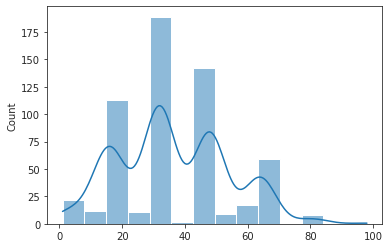

In [47]:
sns.histplot(sizes_np, kde=True)

In [48]:
hcl = mice.parcel.decode(regions2d)[0]

In [52]:
lay0 = regions2d[hcl[:, -1] == 0]
lay1 = regions2d[hcl[:, -1] == 1]

<matplotlib.image.AxesImage object at 0x7ead3b793130>

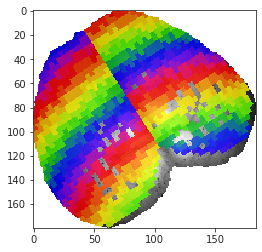

In [55]:
plt.imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay0), roi_tr), alpha=0.8, cmap='prism')

<matplotlib.image.AxesImage object at 0x7eadd4078d30>

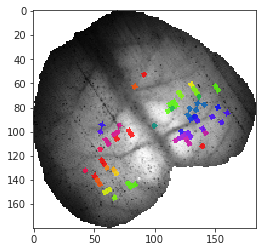

In [56]:
plt.imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay1), roi_tr), alpha=0.8, cmap='prism')

In [64]:
hcl_lay1 = mice.parcel.decode(lay1)[0]
hcl_lay1[:, -1] = 0
lay1_to_0 = mice.parcel.encode(hcl_lay1)

<matplotlib.image.AxesImage object at 0x7eadd491e850>

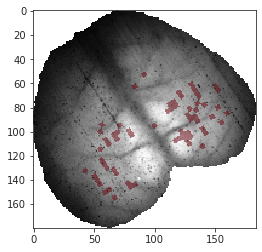

In [74]:
plt.imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay1), roi_tr).astype(bool), alpha=0.5, cmap='Reds_r')
# plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay1_to_0), roi_tr).astype(bool), alpha=0.5, cmap='Greens_r')

<matplotlib.image.AxesImage object at 0x7eadd585fd60>

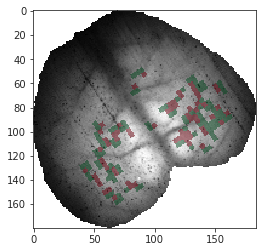

In [75]:
plt.imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay1), roi_tr).astype(bool), alpha=0.5, cmap='Reds_r')
plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay1_to_0), roi_tr).astype(bool), alpha=0.5, cmap='Greens_r')

<matplotlib.image.AxesImage object at 0x7f4291cf74c0>

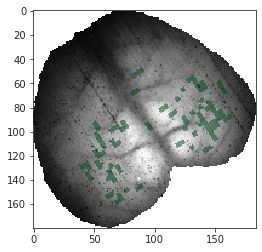

In [77]:
plt.imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
# plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay1), roi_tr).astype(bool), alpha=0.5, cmap='Reds_r')
plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay1_to_0), roi_tr).astype(bool), alpha=0.5, cmap='Greens_r')

In [131]:
a

ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (512, 500, 1)
         Spacing    : (0.025, 0.025, 0.025)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

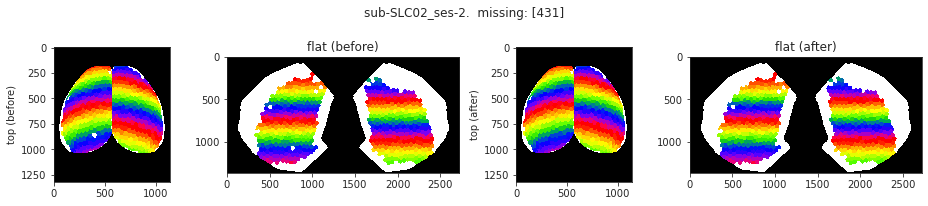

ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (512, 500, 1)
         Spacing    : (0.025, 0.025, 0.025)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [126]:
a = fix_rois_2d(mice)

In [127]:
print(a)

ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (512, 500, 1)
         Spacing    : (0.025, 0.025, 0.025)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.image.AxesImage object at 0x7f8be4077850>

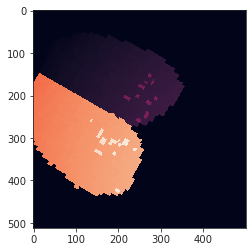

In [128]:
b = a.numpy().squeeze()
plt.imshow(b)

In [129]:
regions = np.unique(b[b.nonzero()])

<matplotlib.image.AxesImage object at 0x7f8be4077df0>

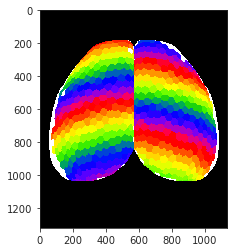

In [130]:
data2plt = np.ma.masked_where(~np.isin(top, regions), top)
plt.imshow(top > 0, cmap='Greys_r')
plt.imshow(data2plt, cmap='prism')